In [1]:
import os
from glob import glob
from dataset import (
    KittiGraphDataset,
    MultipleSequenceGraphDataset,
    KittiSequenceDataset,
)
from torch_geometric.loader import DataLoader
from scipy.spatial.transform import Rotation as R
import torch
from tqdm import tqdm
from model import PoseGNN, PoseLoss
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
os.makedirs("models", exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
basedir = "/home/pcktm/inzynierka/kitti/dataset"
train_sequences = ["00", "01", "02", "03", "04", "05", "06", "07", "08"]

In [56]:
def normalize_position_and_rotation_to_previous(nodes, edge_index, y: list[torch.tensor]) -> tuple:
    # position and rotation are encoded [x, y, z, w, x, y, z] and samples is a list of such vectors
    positions = torch.stack([s[:3] for s in y])
    rotations = torch.stack([s[3:] for s in y])

    # normalize position of each frame to the frame before it, so that the first frame is always [0, 0, 0]
    new_pos = [positions[0] - positions[0]]
    for i in range(1, positions.shape[0]):
        new_pos.append(positions[i] - positions[i - 1])

    new_pos = torch.stack(new_pos)

    # normalize rotation to the frame before it
    new_rot = [R.from_quat(rotations[0]).inv() * R.from_quat(rotations[0])]
    for i in range(1, rotations.shape[0]):
        new_rot.append(R.from_quat(rotations[i]).inv() * R.from_quat(rotations[i - 1]))

    new_rot = torch.tensor([r.as_quat() for r in new_rot], dtype=torch.float32)

    return nodes, edge_index, torch.concatenate((new_pos, new_rot), axis=1)

In [62]:
def normalize_position_and_rotation_to_first(nodes, edge_index, y):
    positions = torch.stack([s[:3] for s in y])
    rotations = torch.stack([s[3:] for s in y])

    # normalize position of each frame to the first frame
    for i in range(positions.shape[0]):
        new_pos.append(positions[i] - positions[0])

    new_pos = torch.stack(new_pos)

    # normalize rotation to the first frame
    new_rot =  []
    for i in range(rotations.shape[0]):
        new_rot.append(R.from_quat(rotations[i]).inv() * R.from_quat(rotations[0]))

    new_rot = torch.tensor([r.as_quat() for r in new_rot], dtype=torch.float32)

    return nodes, edge_index, torch.concatenate((new_pos, new_rot), axis=1)

In [63]:
dataset = MultipleSequenceGraphDataset(
    basedir,
    train_sequences,
    transform=normalize_position_and_rotation_to_first,
    graph_length=7,
)
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

model = PoseGNN().to(device)
criterion = PoseLoss()

In [66]:
optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)
MODEL_LETTER = "D"

loss_history = []
for epoch in range(1, 201):
    model.train()
    epoch_loss_history = []
    progress_bar = tqdm(
        train_dataloader, desc=f"Epoch {epoch}", total=len(train_dataloader)
    )
    for batch in progress_bar:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch.y)
        loss.backward()
        optimizer.step()
        epoch_loss_history.append(loss.item())
        progress_bar.set_postfix({"loss": loss.item()})
       
    loss_history.append(sum(epoch_loss_history) / len(epoch_loss_history))
    print(f"Epoch {epoch} loss: {sum(epoch_loss_history) / len(epoch_loss_history)}")

    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"models/{MODEL_LETTER}/model_{MODEL_LETTER}_{epoch}.pth")

torch.save(model.state_dict(), f"models/{MODEL_LETTER}/model_{MODEL_LETTER}_final.pth")

Epoch 1: 100%|██████████| 159/159 [00:23<00:00,  6.76it/s, loss=2.59]   


Epoch 1 loss: 440.8983653564498


Epoch 2: 100%|██████████| 159/159 [00:23<00:00,  6.76it/s, loss=1.16] 


Epoch 2 loss: 1.1249020084645014


Epoch 3: 100%|██████████| 159/159 [00:23<00:00,  6.64it/s, loss=1.41] 


Epoch 3 loss: 1.032959241162306


Epoch 4: 100%|██████████| 159/159 [00:23<00:00,  6.65it/s, loss=2.15] 


Epoch 4 loss: 1.1221068803244416


Epoch 5: 100%|██████████| 159/159 [00:23<00:00,  6.74it/s, loss=0.678]


Epoch 5 loss: 1.360397903049517


Epoch 6: 100%|██████████| 159/159 [00:23<00:00,  6.73it/s, loss=1.36] 


Epoch 6 loss: 1.271548773882524


Epoch 7: 100%|██████████| 159/159 [00:23<00:00,  6.80it/s, loss=1.54] 


Epoch 7 loss: 1.0873255424154629


Epoch 8: 100%|██████████| 159/159 [00:23<00:00,  6.79it/s, loss=1.88] 


Epoch 8 loss: 1.2492722227888287


Epoch 9: 100%|██████████| 159/159 [00:23<00:00,  6.64it/s, loss=0.984]


Epoch 9 loss: 0.9617463393406298


Epoch 10: 100%|██████████| 159/159 [00:23<00:00,  6.74it/s, loss=0.529]


Epoch 10 loss: 1.048775242559565


Epoch 11: 100%|██████████| 159/159 [00:23<00:00,  6.66it/s, loss=1.64] 


Epoch 11 loss: 1.0289142546038959


Epoch 12: 100%|██████████| 159/159 [00:23<00:00,  6.73it/s, loss=1.22] 


Epoch 12 loss: 1.0790025822396547


Epoch 13: 100%|██████████| 159/159 [00:23<00:00,  6.90it/s, loss=0.849]


Epoch 13 loss: 1.016995700837681


Epoch 14: 100%|██████████| 159/159 [00:23<00:00,  6.87it/s, loss=0.758]


Epoch 14 loss: 0.976812906422705


Epoch 15: 100%|██████████| 159/159 [00:23<00:00,  6.76it/s, loss=1.68] 


Epoch 15 loss: 1.0151358233682763


Epoch 16: 100%|██████████| 159/159 [00:22<00:00,  6.94it/s, loss=0.772]


Epoch 16 loss: 0.9878746646005403


Epoch 17: 100%|██████████| 159/159 [00:23<00:00,  6.90it/s, loss=0.719]


Epoch 17 loss: 1.041218507214912


Epoch 18: 100%|██████████| 159/159 [00:23<00:00,  6.86it/s, loss=1.43] 


Epoch 18 loss: 0.9518638071399065


Epoch 19: 100%|██████████| 159/159 [00:23<00:00,  6.78it/s, loss=1.24] 


Epoch 19 loss: 0.969334122894695


Epoch 20: 100%|██████████| 159/159 [00:23<00:00,  6.80it/s, loss=0.491]


Epoch 20 loss: 0.9400618215027096


Epoch 21: 100%|██████████| 159/159 [00:23<00:00,  6.67it/s, loss=0.974]


Epoch 21 loss: 0.9470067183551548


Epoch 22: 100%|██████████| 159/159 [00:23<00:00,  6.79it/s, loss=0.766]


Epoch 22 loss: 0.9863709561854789


Epoch 23: 100%|██████████| 159/159 [00:23<00:00,  6.74it/s, loss=0.907]


Epoch 23 loss: 0.938619132124403


Epoch 24: 100%|██████████| 159/159 [00:23<00:00,  6.91it/s, loss=1.39] 


Epoch 24 loss: 0.9464194585317336


Epoch 25: 100%|██████████| 159/159 [00:23<00:00,  6.91it/s, loss=1.97] 


Epoch 25 loss: 0.9549587683857612


Epoch 26: 100%|██████████| 159/159 [00:23<00:00,  6.87it/s, loss=0.76] 


Epoch 26 loss: 0.9141263318886547


Epoch 27: 100%|██████████| 159/159 [00:23<00:00,  6.89it/s, loss=0.487]


Epoch 27 loss: 0.9370724500725104


Epoch 28: 100%|██████████| 159/159 [00:23<00:00,  6.89it/s, loss=0.493]


Epoch 28 loss: 0.9283117262072533


Epoch 29: 100%|██████████| 159/159 [00:23<00:00,  6.88it/s, loss=1.18] 


Epoch 29 loss: 0.931062418522325


Epoch 30: 100%|██████████| 159/159 [00:23<00:00,  6.86it/s, loss=0.768]


Epoch 30 loss: 0.9278020530751666


Epoch 31: 100%|██████████| 159/159 [00:23<00:00,  6.88it/s, loss=0.872]


Epoch 31 loss: 0.9025984586409803


Epoch 32: 100%|██████████| 159/159 [00:23<00:00,  6.81it/s, loss=0.945]


Epoch 32 loss: 0.9174770024962395


Epoch 33: 100%|██████████| 159/159 [00:23<00:00,  6.88it/s, loss=0.931]


Epoch 33 loss: 0.9124176106737845


Epoch 34: 100%|██████████| 159/159 [00:23<00:00,  6.83it/s, loss=0.672]


Epoch 34 loss: 0.9040657883545138


Epoch 35: 100%|██████████| 159/159 [00:23<00:00,  6.83it/s, loss=1.21] 


Epoch 35 loss: 2.659299874455674


Epoch 36: 100%|██████████| 159/159 [00:23<00:00,  6.86it/s, loss=1.25] 


Epoch 36 loss: 0.8921008471797847


Epoch 37: 100%|██████████| 159/159 [00:23<00:00,  6.90it/s, loss=1.44] 


Epoch 37 loss: 0.8918048728187129


Epoch 38: 100%|██████████| 159/159 [00:23<00:00,  6.83it/s, loss=1.02] 


Epoch 38 loss: 0.8904855198830178


Epoch 39: 100%|██████████| 159/159 [00:23<00:00,  6.83it/s, loss=0.659]


Epoch 39 loss: 0.8906382772157777


Epoch 40: 100%|██████████| 159/159 [00:23<00:00,  6.76it/s, loss=0.969]


Epoch 40 loss: 0.8891773716833606


Epoch 41: 100%|██████████| 159/159 [00:23<00:00,  6.84it/s, loss=1.03] 


Epoch 41 loss: 0.8885254387585622


Epoch 42: 100%|██████████| 159/159 [00:23<00:00,  6.84it/s, loss=1.65] 


Epoch 42 loss: 0.8884949234296691


Epoch 43: 100%|██████████| 159/159 [00:23<00:00,  6.82it/s, loss=1.15] 


Epoch 43 loss: 0.8865812017857654


Epoch 44: 100%|██████████| 159/159 [00:23<00:00,  6.88it/s, loss=0.449]


Epoch 44 loss: 0.8871090860111909


Epoch 45: 100%|██████████| 159/159 [00:23<00:00,  6.89it/s, loss=0.667]


Epoch 45 loss: 0.8826188986781258


Epoch 46: 100%|██████████| 159/159 [00:23<00:00,  6.88it/s, loss=0.999]


Epoch 46 loss: 0.8858050111704653


Epoch 47: 100%|██████████| 159/159 [00:23<00:00,  6.81it/s, loss=0.963]


Epoch 47 loss: 0.8802534173119743


Epoch 48: 100%|██████████| 159/159 [00:23<00:00,  6.82it/s, loss=1.17] 


Epoch 48 loss: 0.8792382849837249


Epoch 49: 100%|██████████| 159/159 [00:23<00:00,  6.80it/s, loss=0.924]


Epoch 49 loss: 0.8785568666907976


Epoch 50: 100%|██████████| 159/159 [00:23<00:00,  6.85it/s, loss=0.511]


Epoch 50 loss: 0.8734422185510959


Epoch 51: 100%|██████████| 159/159 [00:23<00:00,  6.81it/s, loss=1.39] 


Epoch 51 loss: 0.8762784789568223


Epoch 52: 100%|██████████| 159/159 [00:23<00:00,  6.80it/s, loss=0.746]


Epoch 52 loss: 0.8709898692257


Epoch 53: 100%|██████████| 159/159 [00:23<00:00,  6.80it/s, loss=1.12] 


Epoch 53 loss: 0.8663186447800331


Epoch 54: 100%|██████████| 159/159 [00:23<00:00,  6.80it/s, loss=0.453]


Epoch 54 loss: 0.8744533290653109


Epoch 55: 100%|██████████| 159/159 [00:23<00:00,  6.84it/s, loss=0.678]


Epoch 55 loss: 0.8716389233211301


Epoch 56: 100%|██████████| 159/159 [00:23<00:00,  6.79it/s, loss=0.667]


Epoch 56 loss: 0.8648618442832299


Epoch 57: 100%|██████████| 159/159 [00:23<00:00,  6.80it/s, loss=0.935] 


Epoch 57 loss: 825.4103811360756


Epoch 58: 100%|██████████| 159/159 [00:23<00:00,  6.83it/s, loss=1.48] 


Epoch 58 loss: 0.8912683470444109


Epoch 59: 100%|██████████| 159/159 [00:23<00:00,  6.88it/s, loss=0.899]


Epoch 59 loss: 0.8907744691431897


Epoch 60: 100%|██████████| 159/159 [00:23<00:00,  6.83it/s, loss=1.63] 


Epoch 60 loss: 0.8914496864912644


Epoch 61: 100%|██████████| 159/159 [00:23<00:00,  6.78it/s, loss=0.717]


Epoch 61 loss: 0.8912010464653279


Epoch 62: 100%|██████████| 159/159 [00:23<00:00,  6.85it/s, loss=0.648]


Epoch 62 loss: 0.8910990576699095


Epoch 63: 100%|██████████| 159/159 [00:23<00:00,  6.84it/s, loss=0.611]


Epoch 63 loss: 0.8910815185345944


Epoch 64: 100%|██████████| 159/159 [00:23<00:00,  6.82it/s, loss=0.648]


Epoch 64 loss: 0.8911577689947572


Epoch 65: 100%|██████████| 159/159 [00:23<00:00,  6.81it/s, loss=0.682]


Epoch 65 loss: 0.8914548426679095


Epoch 66: 100%|██████████| 159/159 [00:23<00:00,  6.79it/s, loss=0.96] 


Epoch 66 loss: 0.8914257842789656


Epoch 67: 100%|██████████| 159/159 [00:23<00:00,  6.80it/s, loss=1.21] 


Epoch 67 loss: 0.8916833721241861


Epoch 68: 100%|██████████| 159/159 [00:23<00:00,  6.80it/s, loss=0.726]


Epoch 68 loss: 0.8916657165911213


Epoch 69: 100%|██████████| 159/159 [00:23<00:00,  6.74it/s, loss=0.42] 


Epoch 69 loss: 0.8912909675694112


Epoch 70: 100%|██████████| 159/159 [00:23<00:00,  6.79it/s, loss=0.977]


Epoch 70 loss: 0.8919129911458717


Epoch 71: 100%|██████████| 159/159 [00:23<00:00,  6.86it/s, loss=0.78] 


Epoch 71 loss: 0.8918222138341868


Epoch 72: 100%|██████████| 159/159 [00:23<00:00,  6.88it/s, loss=0.728]


Epoch 72 loss: 0.892143503112613


Epoch 73: 100%|██████████| 159/159 [00:22<00:00,  7.00it/s, loss=0.905]


Epoch 73 loss: 0.8921796267137587


Epoch 74: 100%|██████████| 159/159 [00:22<00:00,  7.08it/s, loss=1.14] 


Epoch 74 loss: 0.8924927919540765


Epoch 75: 100%|██████████| 159/159 [00:22<00:00,  7.01it/s, loss=0.955]


Epoch 75 loss: 0.893777423122394


Epoch 76: 100%|██████████| 159/159 [00:22<00:00,  7.06it/s, loss=0.8]  


Epoch 76 loss: 0.8920085227714395


Epoch 77: 100%|██████████| 159/159 [00:22<00:00,  7.03it/s, loss=0.954]


Epoch 77 loss: 0.8925804593278177


Epoch 78: 100%|██████████| 159/159 [00:22<00:00,  7.01it/s, loss=1.41] 


Epoch 78 loss: 0.8937376042207082


Epoch 79: 100%|██████████| 159/159 [00:22<00:00,  7.02it/s, loss=0.984]


Epoch 79 loss: 0.8936944562684065


Epoch 80: 100%|██████████| 159/159 [00:22<00:00,  7.03it/s, loss=1.68] 


Epoch 80 loss: 0.8949696678410536


Epoch 81: 100%|██████████| 159/159 [00:22<00:00,  7.05it/s, loss=1.59] 


Epoch 81 loss: 0.8959123141735604


Epoch 82: 100%|██████████| 159/159 [00:22<00:00,  7.03it/s, loss=0.94] 


Epoch 82 loss: 0.8959618034602711


Epoch 83: 100%|██████████| 159/159 [00:22<00:00,  6.98it/s, loss=0.46] 


Epoch 83 loss: 0.9013559287823971


Epoch 84: 100%|██████████| 159/159 [00:22<00:00,  7.09it/s, loss=0.692]


Epoch 84 loss: 0.899888831114619


Epoch 85: 100%|██████████| 159/159 [00:22<00:00,  7.09it/s, loss=1.01] 


Epoch 85 loss: 0.8981031065092147


Epoch 86: 100%|██████████| 159/159 [00:22<00:00,  7.03it/s, loss=0.482]


Epoch 86 loss: 0.9034852098743871


Epoch 87: 100%|██████████| 159/159 [00:22<00:00,  7.03it/s, loss=0.888]


Epoch 87 loss: 0.9021250599960111


Epoch 88: 100%|██████████| 159/159 [00:22<00:00,  7.04it/s, loss=1.01] 


Epoch 88 loss: 0.9001699742281212


Epoch 89: 100%|██████████| 159/159 [00:22<00:00,  7.07it/s, loss=0.945]


Epoch 89 loss: 0.9070969992463693


Epoch 90: 100%|██████████| 159/159 [00:22<00:00,  7.06it/s, loss=1.02] 


Epoch 90 loss: 0.9090331970895611


Epoch 91: 100%|██████████| 159/159 [00:22<00:00,  7.01it/s, loss=1.19] 


Epoch 91 loss: 0.9063442178867148


Epoch 92: 100%|██████████| 159/159 [00:22<00:00,  6.98it/s, loss=1.24] 


Epoch 92 loss: 0.9117270816796981


Epoch 93: 100%|██████████| 159/159 [00:22<00:00,  7.04it/s, loss=0.628]


Epoch 93 loss: 0.9140949637260077


Epoch 94: 100%|██████████| 159/159 [00:22<00:00,  7.05it/s, loss=0.982]


Epoch 94 loss: 0.9127776446582386


Epoch 95: 100%|██████████| 159/159 [00:22<00:00,  7.01it/s, loss=1.15] 


Epoch 95 loss: 0.9046377344701275


Epoch 96: 100%|██████████| 159/159 [00:22<00:00,  7.05it/s, loss=0.703]


Epoch 96 loss: 0.9092611246888742


Epoch 97: 100%|██████████| 159/159 [00:22<00:00,  7.02it/s, loss=0.498]


Epoch 97 loss: 0.9133019284257349


Epoch 98: 100%|██████████| 159/159 [00:22<00:00,  7.05it/s, loss=0.734]


Epoch 98 loss: 0.9063659435922995


Epoch 99: 100%|██████████| 159/159 [00:22<00:00,  7.03it/s, loss=0.54] 


Epoch 99 loss: 0.9083428178568306


Epoch 100: 100%|██████████| 159/159 [00:22<00:00,  6.99it/s, loss=1.18] 


Epoch 100 loss: 0.9116711972644495


Epoch 101: 100%|██████████| 159/159 [00:22<00:00,  7.03it/s, loss=0.938]


Epoch 101 loss: 0.9073139301635934


Epoch 102: 100%|██████████| 159/159 [00:22<00:00,  7.03it/s, loss=0.485]


Epoch 102 loss: 0.9075599144089896


Epoch 103: 100%|██████████| 159/159 [00:22<00:00,  7.01it/s, loss=0.672]


Epoch 103 loss: 0.919453797662783


Epoch 104: 100%|██████████| 159/159 [00:22<00:00,  7.06it/s, loss=0.46] 


Epoch 104 loss: 0.896918165421336


Epoch 105: 100%|██████████| 159/159 [00:22<00:00,  7.04it/s, loss=0.981]


Epoch 105 loss: 0.9100051653460137


Epoch 106: 100%|██████████| 159/159 [00:22<00:00,  7.06it/s, loss=0.936]


Epoch 106 loss: 0.9084345880169539


Epoch 107: 100%|██████████| 159/159 [00:22<00:00,  7.02it/s, loss=1.45] 


Epoch 107 loss: 0.902350144378794


Epoch 108: 100%|██████████| 159/159 [00:22<00:00,  7.02it/s, loss=1.44] 


Epoch 108 loss: 0.8910785949080245


Epoch 109: 100%|██████████| 159/159 [00:22<00:00,  7.01it/s, loss=0.84] 


Epoch 109 loss: 0.8982784776192791


Epoch 110: 100%|██████████| 159/159 [00:22<00:00,  7.04it/s, loss=0.744]


Epoch 110 loss: 0.899588331861316


Epoch 111: 100%|██████████| 159/159 [00:22<00:00,  7.03it/s, loss=0.688]


Epoch 111 loss: 0.8865800773572622


Epoch 112: 100%|██████████| 159/159 [00:22<00:00,  7.03it/s, loss=0.704]


Epoch 112 loss: 0.8840329901977155


Epoch 113: 100%|██████████| 159/159 [00:22<00:00,  7.11it/s, loss=1.68] 


Epoch 113 loss: 0.8845587747651826


Epoch 114: 100%|██████████| 159/159 [00:22<00:00,  7.13it/s, loss=0.632]


Epoch 114 loss: 0.8793256914465682


Epoch 115: 100%|██████████| 159/159 [00:22<00:00,  7.06it/s, loss=0.633]


Epoch 115 loss: 0.8698321732709993


Epoch 116: 100%|██████████| 159/159 [00:22<00:00,  7.06it/s, loss=0.908]


Epoch 116 loss: 0.862415316157371


Epoch 117: 100%|██████████| 159/159 [00:22<00:00,  7.00it/s, loss=0.42] 


Epoch 117 loss: 0.8722216010843433


Epoch 118: 100%|██████████| 159/159 [00:22<00:00,  7.01it/s, loss=1.31] 


Epoch 118 loss: 0.8570263273311112


Epoch 119: 100%|██████████| 159/159 [00:22<00:00,  7.03it/s, loss=0.886]


Epoch 119 loss: 0.8507081090279345


Epoch 120: 100%|██████████| 159/159 [00:22<00:00,  6.99it/s, loss=0.918]


Epoch 120 loss: 0.8424636378603162


Epoch 121: 100%|██████████| 159/159 [00:22<00:00,  7.08it/s, loss=0.608]


Epoch 121 loss: 0.8377247563323135


Epoch 122: 100%|██████████| 159/159 [00:22<00:00,  7.01it/s, loss=0.848]


Epoch 122 loss: 0.8276247890115535


Epoch 123: 100%|██████████| 159/159 [00:22<00:00,  7.01it/s, loss=1.08] 


Epoch 123 loss: 0.8306654774168003


Epoch 124: 100%|██████████| 159/159 [00:22<00:00,  7.00it/s, loss=1.54] 


Epoch 124 loss: 0.8274586343165463


Epoch 125: 100%|██████████| 159/159 [00:22<00:00,  7.05it/s, loss=1.53] 


Epoch 125 loss: 0.8220916178616338


Epoch 126: 100%|██████████| 159/159 [00:22<00:00,  7.03it/s, loss=0.855]


Epoch 126 loss: 0.8139809017661233


Epoch 127: 100%|██████████| 159/159 [00:22<00:00,  7.05it/s, loss=0.655]


Epoch 127 loss: 0.8121352053288394


Epoch 128: 100%|██████████| 159/159 [00:22<00:00,  7.03it/s, loss=0.325]


Epoch 128 loss: 0.8162041896919034


Epoch 129: 100%|██████████| 159/159 [00:22<00:00,  7.03it/s, loss=0.85] 


Epoch 129 loss: 0.7958792894141479


Epoch 130: 100%|██████████| 159/159 [00:22<00:00,  7.08it/s, loss=1.05] 


Epoch 130 loss: 0.8057111376111612


Epoch 131: 100%|██████████| 159/159 [00:22<00:00,  7.07it/s, loss=0.583]


Epoch 131 loss: 0.7920117739986323


Epoch 132: 100%|██████████| 159/159 [00:22<00:00,  7.07it/s, loss=0.395]


Epoch 132 loss: 0.8021327536435997


Epoch 133: 100%|██████████| 159/159 [00:22<00:00,  7.04it/s, loss=1.08] 


Epoch 133 loss: 0.7953897330371089


Epoch 134: 100%|██████████| 159/159 [00:22<00:00,  7.02it/s, loss=0.933]


Epoch 134 loss: 0.7947640941952759


Epoch 135: 100%|██████████| 159/159 [00:22<00:00,  7.03it/s, loss=1.07] 


Epoch 135 loss: 0.7937807215834564


Epoch 136: 100%|██████████| 159/159 [00:22<00:00,  7.06it/s, loss=1.6]  


Epoch 136 loss: 0.7920539277904438


Epoch 137: 100%|██████████| 159/159 [00:22<00:00,  7.08it/s, loss=0.608]


Epoch 137 loss: 0.7875953159242306


Epoch 138: 100%|██████████| 159/159 [00:22<00:00,  7.07it/s, loss=0.807]


Epoch 138 loss: 0.7846491906627919


Epoch 139: 100%|██████████| 159/159 [00:22<00:00,  7.05it/s, loss=0.591]


Epoch 139 loss: 0.787115326280114


Epoch 140: 100%|██████████| 159/159 [00:22<00:00,  6.98it/s, loss=0.319]


Epoch 140 loss: 0.7870960835390871


Epoch 141: 100%|██████████| 159/159 [00:22<00:00,  7.04it/s, loss=1.07] 


Epoch 141 loss: 0.7821237666052092


Epoch 142: 100%|██████████| 159/159 [00:22<00:00,  7.05it/s, loss=1.05] 


Epoch 142 loss: 0.7780949203473218


Epoch 143: 100%|██████████| 159/159 [00:22<00:00,  7.04it/s, loss=1.28] 


Epoch 143 loss: 0.787245272278036


Epoch 144: 100%|██████████| 159/159 [00:22<00:00,  7.05it/s, loss=0.389]


Epoch 144 loss: 0.7796866438298855


Epoch 145: 100%|██████████| 159/159 [00:22<00:00,  7.07it/s, loss=0.548]


Epoch 145 loss: 0.7763751049836477


Epoch 146: 100%|██████████| 159/159 [00:22<00:00,  7.07it/s, loss=0.628]


Epoch 146 loss: 0.7774356612994237


Epoch 147: 100%|██████████| 159/159 [00:22<00:00,  7.06it/s, loss=0.878]


Epoch 147 loss: 0.7714127330285199


Epoch 148: 100%|██████████| 159/159 [00:22<00:00,  7.08it/s, loss=0.791]


Epoch 148 loss: 0.7946584728903741


Epoch 149: 100%|██████████| 159/159 [00:22<00:00,  7.04it/s, loss=1.75] 


Epoch 149 loss: 0.7698894784135638


Epoch 150: 100%|██████████| 159/159 [00:22<00:00,  7.08it/s, loss=1.26] 


Epoch 150 loss: 0.7770966536968759


Epoch 151: 100%|██████████| 159/159 [00:22<00:00,  7.05it/s, loss=0.599]


Epoch 151 loss: 0.7689469889649805


Epoch 152: 100%|██████████| 159/159 [00:22<00:00,  7.03it/s, loss=36.6]   


Epoch 152 loss: 11.225778799012023


Epoch 153: 100%|██████████| 159/159 [00:22<00:00,  7.01it/s, loss=0.569]


Epoch 153 loss: 4.09738840397049


Epoch 154: 100%|██████████| 159/159 [00:22<00:00,  7.07it/s, loss=1.28] 


Epoch 154 loss: 0.8992594493635045


Epoch 155: 100%|██████████| 159/159 [00:22<00:00,  7.05it/s, loss=1.26] 


Epoch 155 loss: 0.8687900647802173


Epoch 156: 100%|██████████| 159/159 [00:22<00:00,  7.04it/s, loss=0.874]


Epoch 156 loss: 0.9167335069029586


Epoch 157: 100%|██████████| 159/159 [00:22<00:00,  7.02it/s, loss=0.452]


Epoch 157 loss: 0.8621840611943659


Epoch 158: 100%|██████████| 159/159 [00:22<00:00,  7.07it/s, loss=0.648]


Epoch 158 loss: 0.8752480203625541


Epoch 159: 100%|██████████| 159/159 [00:22<00:00,  7.05it/s, loss=0.661]


Epoch 159 loss: 0.8601653296617592


Epoch 160: 100%|██████████| 159/159 [00:22<00:00,  7.02it/s, loss=0.831]


Epoch 160 loss: 0.8746599054561471


Epoch 161: 100%|██████████| 159/159 [00:22<00:00,  7.10it/s, loss=1.3]  


Epoch 161 loss: 0.8554754036027681


Epoch 162: 100%|██████████| 159/159 [00:22<00:00,  7.09it/s, loss=0.39] 


Epoch 162 loss: 0.8604961882972118


Epoch 163: 100%|██████████| 159/159 [00:22<00:00,  7.10it/s, loss=0.383]


Epoch 163 loss: 0.8625603769935152


Epoch 164: 100%|██████████| 159/159 [00:22<00:00,  7.06it/s, loss=0.661]


Epoch 164 loss: 0.8423636670007646


Epoch 165: 100%|██████████| 159/159 [00:22<00:00,  7.11it/s, loss=0.888]


Epoch 165 loss: 0.8380226830266556


Epoch 166: 100%|██████████| 159/159 [00:22<00:00,  7.05it/s, loss=1.34] 


Epoch 166 loss: 0.8485219701656006


Epoch 167: 100%|██████████| 159/159 [00:22<00:00,  7.10it/s, loss=0.472]


Epoch 167 loss: 0.8253685344690047


Epoch 168: 100%|██████████| 159/159 [00:22<00:00,  7.08it/s, loss=0.638]


Epoch 168 loss: 0.8376063968775407


Epoch 169: 100%|██████████| 159/159 [00:22<00:00,  7.04it/s, loss=0.842]


Epoch 169 loss: 0.8112412610518858


Epoch 170: 100%|██████████| 159/159 [00:22<00:00,  7.12it/s, loss=1.12] 


Epoch 170 loss: 0.8348723640606838


Epoch 171: 100%|██████████| 159/159 [00:22<00:00,  7.11it/s, loss=0.642]


Epoch 171 loss: 0.8407212298996044


Epoch 172: 100%|██████████| 159/159 [00:22<00:00,  7.08it/s, loss=0.609]


Epoch 172 loss: 0.7894807214257102


Epoch 173: 100%|██████████| 159/159 [00:22<00:00,  7.08it/s, loss=1.15] 


Epoch 173 loss: 0.8157915872222973


Epoch 174: 100%|██████████| 159/159 [00:22<00:00,  7.07it/s, loss=0.606]


Epoch 174 loss: 0.8042549267879822


Epoch 175: 100%|██████████| 159/159 [00:22<00:00,  7.11it/s, loss=0.633]


Epoch 175 loss: 0.8195307069229629


Epoch 176: 100%|██████████| 159/159 [00:22<00:00,  7.06it/s, loss=0.579]


Epoch 176 loss: 0.7982682274572505


Epoch 177: 100%|██████████| 159/159 [00:22<00:00,  7.04it/s, loss=0.397]


Epoch 177 loss: 0.800886609831696


Epoch 178: 100%|██████████| 159/159 [00:22<00:00,  7.07it/s, loss=0.584]


Epoch 178 loss: 0.8032781590455733


Epoch 179: 100%|██████████| 159/159 [00:22<00:00,  7.08it/s, loss=1.03] 


Epoch 179 loss: 0.7794830602294994


Epoch 180: 100%|██████████| 159/159 [00:22<00:00,  7.03it/s, loss=1.06] 


Epoch 180 loss: 0.7976366317122238


Epoch 181: 100%|██████████| 159/159 [00:22<00:00,  7.03it/s, loss=0.893]


Epoch 181 loss: 0.8071463216775618


Epoch 182: 100%|██████████| 159/159 [00:22<00:00,  7.07it/s, loss=0.397]


Epoch 182 loss: 0.7734583361343768


Epoch 183: 100%|██████████| 159/159 [00:22<00:00,  7.03it/s, loss=0.615]


Epoch 183 loss: 0.7913466103421817


Epoch 184: 100%|██████████| 159/159 [00:22<00:00,  7.08it/s, loss=0.409]


Epoch 184 loss: 0.7806516130390407


Epoch 185: 100%|██████████| 159/159 [00:22<00:00,  7.08it/s, loss=0.575]


Epoch 185 loss: 0.7860513464459833


Epoch 186: 100%|██████████| 159/159 [00:22<00:00,  7.04it/s, loss=0.533]


Epoch 186 loss: 0.7758406095159879


Epoch 187: 100%|██████████| 159/159 [00:22<00:00,  7.05it/s, loss=0.806]


Epoch 187 loss: 0.7789437384725367


Epoch 188: 100%|██████████| 159/159 [00:22<00:00,  7.11it/s, loss=0.999]


Epoch 188 loss: 0.7727703952564383


Epoch 189: 100%|██████████| 159/159 [00:22<00:00,  7.07it/s, loss=1.08] 


Epoch 189 loss: 0.7791453573688771


Epoch 190: 100%|██████████| 159/159 [00:22<00:00,  7.12it/s, loss=0.801]


Epoch 190 loss: 0.7718994636205757


Epoch 191: 100%|██████████| 159/159 [00:22<00:00,  7.03it/s, loss=1.06] 


Epoch 191 loss: 0.7688549955685934


Epoch 192: 100%|██████████| 159/159 [00:22<00:00,  7.08it/s, loss=0.86] 


Epoch 192 loss: 0.7834319809697708


Epoch 193: 100%|██████████| 159/159 [00:22<00:00,  7.06it/s, loss=1.88]  


Epoch 193 loss: 24.068072328215127


Epoch 194: 100%|██████████| 159/159 [00:22<00:00,  7.06it/s, loss=1.09] 


Epoch 194 loss: 0.9180996515465982


Epoch 195: 100%|██████████| 159/159 [00:22<00:00,  7.09it/s, loss=0.752]


Epoch 195 loss: 0.9077257066027923


Epoch 196: 100%|██████████| 159/159 [00:22<00:00,  7.09it/s, loss=0.715]


Epoch 196 loss: 0.9078865197469603


Epoch 197: 100%|██████████| 159/159 [00:22<00:00,  7.08it/s, loss=1.15] 


Epoch 197 loss: 0.9094250878822878


Epoch 198: 100%|██████████| 159/159 [00:22<00:00,  7.12it/s, loss=0.963]


Epoch 198 loss: 0.9181440026505189


Epoch 199: 100%|██████████| 159/159 [00:22<00:00,  7.08it/s, loss=0.634]


Epoch 199 loss: 0.9353332793187795


Epoch 200: 100%|██████████| 159/159 [00:22<00:00,  7.04it/s, loss=0.501]

Epoch 200 loss: 0.9024945212610113


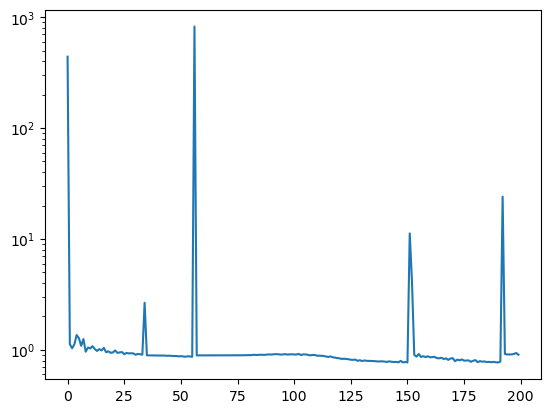

In [67]:
# plot loss
plt.plot(loss_history)
plt.yscale("log")
plt.show()